In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [47]:
import os
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
base_folder = 'colab/data/test/dog'
class_folders = os.listdir(base_folder)

In [5]:
image_paths = []
json_paths = []

for class_folder in class_folders:
    image_files = glob.glob(os.path.join(base_folder, class_folder, '*.jpg'))
    json_files = [file.replace('.jpg', '.json') for file in image_files]

    image_paths.extend(image_files)
    json_paths.extend(json_files)

image_paths = [path.replace('\\', '/') for path in image_paths]
json_paths = [path.replace('\\', '/') for path in json_paths]

df = pd.DataFrame({
    'image_path': image_paths,
    'json_path': json_paths,
    'label': [path.split('/')[-2] for path in image_paths]
})

In [6]:
df

,image_path,json_path,label
0,colab/data/test/dog/A1/IMG_D_A1_004832.jpg,colab/data/test/dog/A1/IMG_D_A1_004832.json,A1
1,colab/data/test/dog/A1/IMG_D_A1_004842.jpg,colab/data/test/dog/A1/IMG_D_A1_004842.json,A1
2,colab/data/test/dog/A1/IMG_D_A1_004836.jpg,colab/data/test/dog/A1/IMG_D_A1_004836.json,A1
3,colab/data/test/dog/A1/IMG_D_A1_004818.jpg,colab/data/test/dog/A1/IMG_D_A1_004818.json,A1
4,colab/data/test/dog/A1/IMG_D_A1_004820.jpg,colab/data/test/dog/A1/IMG_D_A1_004820.json,A1
...,...,...,...
29995,colab/data/test/dog/A6/IMG_D_A6_203691.jpg,colab/data/test/dog/A6/IMG_D_A6_203691.json,A6
29996,colab/data/test/dog/A6/IMG_D_A6_203671.jpg,colab/data/test/dog/A6/IMG_D_A6_203671.json,A6
29997,colab/data/test/dog/A6/IMG_D_A6_203677.jpg,colab/data/test/dog/A6/IMG_D_A6_203677.json,A6
29998,colab/data/test/dog/A6/IMG_D_A6_203679.jpg,colab/data/test/dog/A6/IMG_D_A6_203679.json,A6


In [43]:
def create_mask(image_path, json_path):
    try:
        with Image.open(image_path) as img:
            original_size = img.size
            img = img.resize((600, 600))
            image = np.array(img, dtype=np.float32)

        with open(json_path, 'r', encoding='UTF-8') as file:
            data = json.load(file)

        mask = Image.new('L', original_size, 0)
        draw = ImageDraw.Draw(mask)

        for annotation in data['labelingInfo']:
            if 'polygon' in annotation:
                polygon = []
                for i in range(1, len(annotation['polygon']['location'][0]) // 2 + 1):
                    x_key = f'x{i}'
                    y_key = f'y{i}'
                    x = annotation['polygon']['location'][0].get(x_key)
                    y = annotation['polygon']['location'][0].get(y_key)
                    if x is not None and y is not None:
                        polygon.append((x, y))

                if polygon:
                    draw.polygon(polygon, outline=1, fill=1)

        mask = mask.resize((600, 600))
        mask = np.array(mask, dtype=np.float32)
        mask = np.expand_dims(mask, axis=-1)

        return image, mask
    except Exception as e:
        empty_image = np.zeros((600, 600, 3), dtype=np.float32)
        empty_mask = np.zeros((600, 600, 1), dtype=np.float32)
        return empty_image, empty_mask

def create_masked_image(image, mask):
    masked_image = tf.where(mask > 0, image, tf.zeros_like(image))
    if masked_image.shape[-1] == 1:
        masked_image = tf.image.grayscale_to_rgb(masked_image)
    return masked_image

keys_tensor = tf.constant(['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])
vals_tensor = tf.constant([0, 1, 2, 3, 4, 5], dtype=tf.int64)
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)

def map_labels(label):
    return table.lookup(label)

def prepare_dataset(image_path, json_path, label):
    image, mask = create_mask(image_path, json_path)
    masked_image = create_masked_image(image, mask)

    label_index = map_labels(label)
    one_hot_label = tf.one_hot(label_index, depth=6)
    return masked_image, one_hot_label

In [48]:
def build_efficientnet_model(num_classes, dropout_rate=0.5):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
    base_model.trainable = False  # Transfer learning: base model is not trainable

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    predictions = Dense(num_classes, activation='softmax')(x)


    initial_learning_rate = 0.001

    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule)

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
# 모델 생성
efficientnet_model = build_efficientnet_model(num_classes=6)

# 콜백 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('colab/model/Efficient_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 데이터셋 생성 및 전처리
dataset = tf.data.Dataset.from_tensor_slices((df['image_path'], df['json_path'], df['label']))
dataset = dataset.map(prepare_dataset, num_parallel_calls=tf.data.AUTOTUNE)


# 데이터셋 분할: 훈련과 검증
train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

In [50]:
history = efficientnet_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
750/750 [==============================] - ETA: 0s - loss: 1.8677 - accuracy: 0.9287
Epoch 1: val_loss improved from inf to 68.05585, saving model to colab/model/Efficient_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 2703s 4s/step - loss: 1.8677 - accuracy: 0.9287 - val_loss: 68.0558 - val_accuracy: 0.1667
Epoch 2/50
750/750 [==============================] - ETA: 0s - loss: 1.7302 - accuracy: 0.8531
Epoch 2: val_loss improved from 68.05585 to 9.08717, saving model to colab/model/Efficient_best_model.h5
750/750 [==============================] - 2652s 4s/step - loss: 1.7302 - accuracy: 0.8531 - val_loss: 9.0872 - val_accuracy: 0.1667
Epoch 3/50
750/750 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.7577
Epoch 3: val_loss improved from 9.08717 to 7.08412, saving model to colab/model/Efficient_best_model.h5
750/750 [==============================] - 2648s 4s/step - loss: 0.9136 - accuracy: 0.7577 - val_loss: 7.0841 - val_accuracy: 0.1667
Epoch 4/50
750/750 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.5852

KeyboardInterrupt: ignored

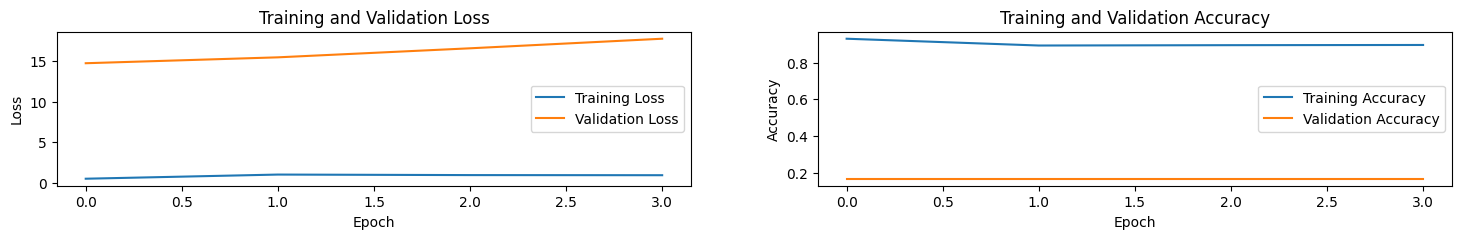

In [51]:
plt.figure(figsize=(18, 2))

# 훈련 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()